<a href="https://colab.research.google.com/github/shaswata09/Offroad-Path-Planning/blob/main/Road_Extractor_Ensemble_CAVS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U albumentations

!pip install --upgrade opencv-python

!pip install segmentation-models-pytorch==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 6.9 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.5 MB/s 
     |████████████████████████████████| 376 kB 33.6 MB/s 
     |████████████████████████████████| 58 kB 7.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=c4601df24bbb9aee2e303096ab9bdf170d442a1f5cd66d1164ca68d776667d49
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Creat

In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [4]:
DATA_DIR = './cavs_flight_labels/'

x_train_dir = os.path.join(DATA_DIR, 'train', 'original_image')
y_train_dir = os.path.join(DATA_DIR, 'train', 'ground_truth')
print(x_train_dir)
print(y_train_dir)

x_valid_dir = os.path.join(DATA_DIR, 'val', 'original_image')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'ground_truth')
print(x_valid_dir)
print(y_valid_dir)

x_test_dir = os.path.join(DATA_DIR, 'test', 'original_image')
y_test_dir = os.path.join(DATA_DIR, 'test', 'ground_truth')
print(x_test_dir)
print(y_test_dir)

./cavs_flight_labels/train/original_image
./cavs_flight_labels/train/ground_truth
./cavs_flight_labels/val/original_image
./cavs_flight_labels/val/ground_truth
./cavs_flight_labels/test/original_image
./cavs_flight_labels/test/ground_truth


In [5]:
class_dict = pd.read_csv("./cavs_flight_labels/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [6]:
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', select_classes)
print('Class RGB values: ', select_class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[  0   0   0]
 [255 255 255]]


In [7]:
from numpy.ma.core import shape
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        # print(shape(label))
        # print(colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    # print(shape(semantic_map))
    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    # print(shape(x))
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    # print(image.astype(int))
    # print(shape(x))

    return x

In [8]:
class RoadsDataset(torch.utils.data.Dataset):

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # print(self.image_paths[i] , '---', self.mask_paths[i])
        # print(i)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [9]:
def get_training_augmentation():
    train_transform = [    
        album.Resize(height=256, width=384, interpolation=cv2.INTER_NEAREST),
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)



def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

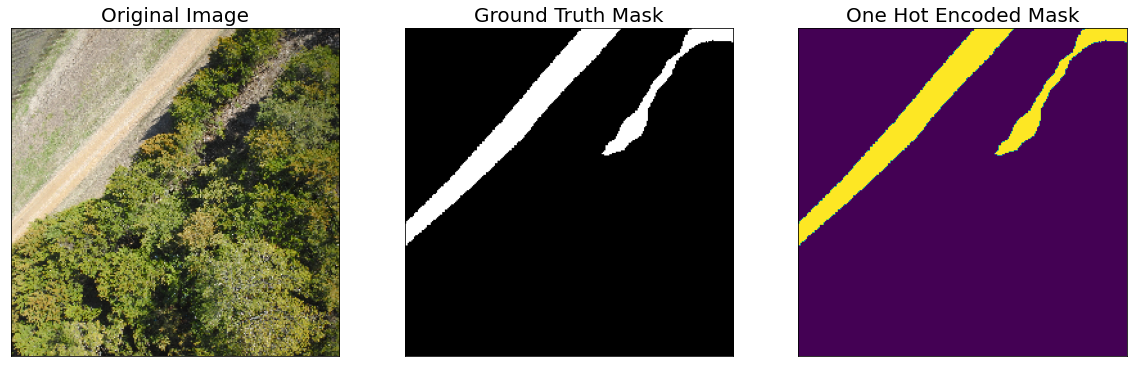

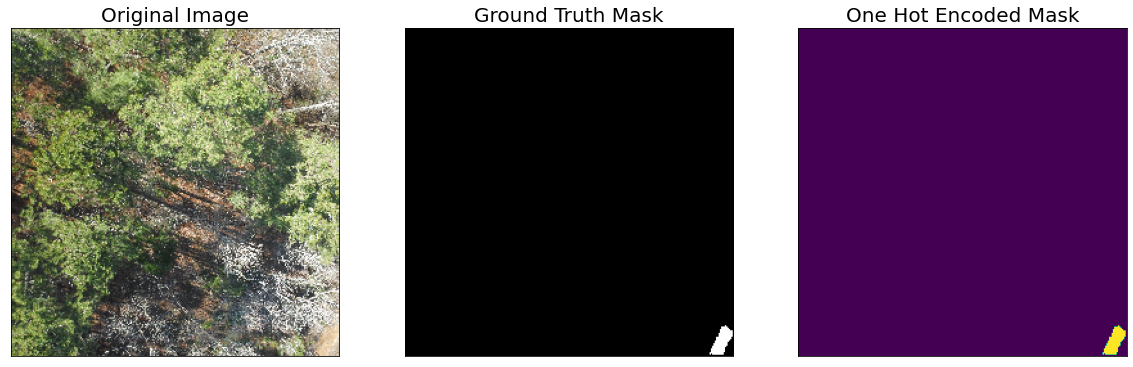

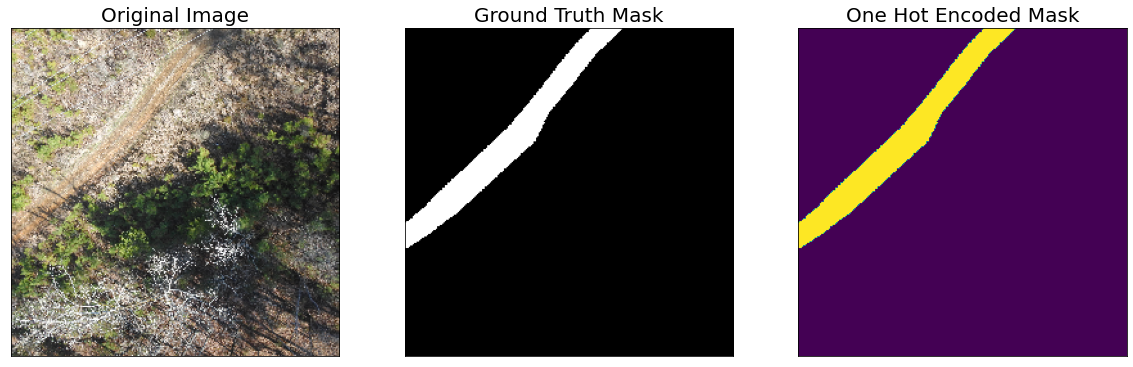

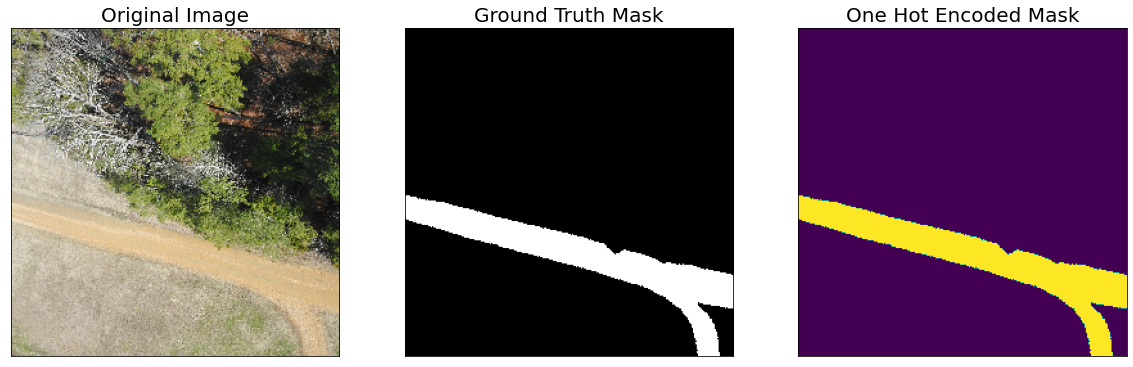

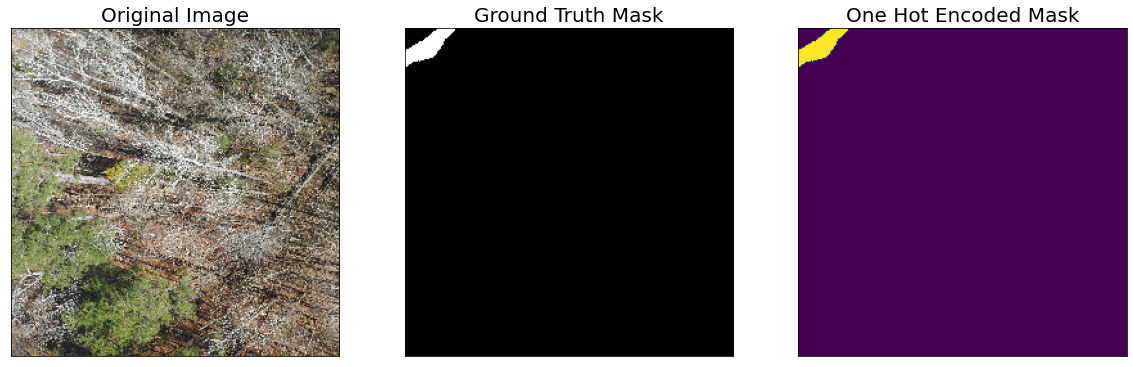

In [10]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(5):

    random_idx = random.randint(0, len(augmented_dataset)-1)
    image, mask = augmented_dataset[random_idx]
    # print(image.shape, mask.shape )
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )


In [11]:
# https://github.com/qubvel/segmentation_models.pytorch#encoders
# Test with the other models in the above link
####################################
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'softmax' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model_deepLab = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

model_unet = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# load best saved Unet model checkpoint from the current run
if os.path.exists('./best_model_unet_softmax_cavs.pth'):
    best_model_unet = torch.load('./best_model_unet_softmax_cavs.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

else:
  print('Error!!! Unable to load model from drive.')

Loaded UNet model from this run.


In [14]:
# load best saved DeepLab model checkpoint from the current run
if os.path.exists('./best_model_deeplab_softmax_cavs.pth'):
    best_model_deepLab = torch.load('./best_model_deeplab_softmax_cavs.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

else:
  print('Error!!! Unable to load model from drive.')

Loaded DeepLabV3+ model from this run.


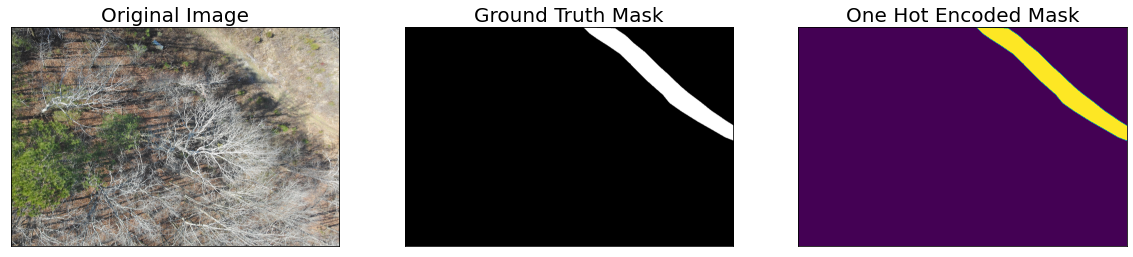

In [15]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [16]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[256,256,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]


def preprocess_resize_image(image):
  # image = torch.from_numpy(image)
  # image = image.permute(1,2,0)
  # image = image.cpu().detach().numpy()
  # image = cv2.resize(image, (1536, 1536), interpolation = cv2.INTER_AREA)
  # image = torch.from_numpy(image)
  # image = image.permute(2,0, 1)
  # image = image.cpu().detach().numpy()
  image = np.transpose(image, (1,2,0))
  image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_AREA)
  image = np.transpose(image, (2,0,1))
  return image

In [ ]:
sample_preds_folder = 'sample_predictions/'
original_image_folder = 'original_image/'
ground_truth_folder = 'ground_truth/'
predictions_folder = 'predictions/'
prediction_matrix = 'prediction_matrix/'
# road_heatmap_folder = 'road_heatmap/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder + original_image_folder)
    os.makedirs(sample_preds_folder + ground_truth_folder)
    os.makedirs(sample_preds_folder + predictions_folder)
    os.makedirs(sample_preds_folder + prediction_matrix)
    # os.makedirs(sample_preds_folder + road_heatmap_folder)

In [17]:
def get_ensemble_maxpool_prediction(pred_mask_unet, pred_mask_deepLab):

  # print(pred_mask_unet[0][0] if pred_mask_unet[0][0][1] > pred_mask_deepLab[0][0][1] else pred_mask_deepLab[0][0] )

  pred_mask_ensemble = pred_mask_unet.copy()

  if pred_mask_unet.shape == pred_mask_deepLab.shape:
    for i in range(pred_mask_unet.shape[0]):
      for j in range(pred_mask_unet.shape[1]):
       pred_mask_ensemble[i][j] = pred_mask_unet[i][j] if pred_mask_unet[i][j][1] > pred_mask_deepLab[i][j][1] else pred_mask_deepLab[i][j]
  else:
    print("Error!!! Prediction matrix error occured.")

  return pred_mask_ensemble

In [18]:
def get_iou_score(pred_mask_ensemble, pred_mask_groundtruth):
  iou = smp.utils.metrics.IoU(threshold=0.5)
  return iou.forward(pred_mask_ensemble, pred_mask_groundtruth)

In [19]:
def get_dice_loss(pred_mask_ensemble, pred_mask_groundtruth):
  d_loss = smp.utils.losses.DiceLoss()
  return d_loss.forward(pred_mask_ensemble, pred_mask_groundtruth)

Ensemble IoU:  tensor(0.1560)
Ensemble Dice Loss:  tensor(0.7298)
UNet IoU:  tensor(0.3934)
UNet Dice Loss:  tensor(0.4349)
DeepLab IoU:  tensor(5.1387e-11)
DeepLab Dice Loss:  tensor(0.9995)


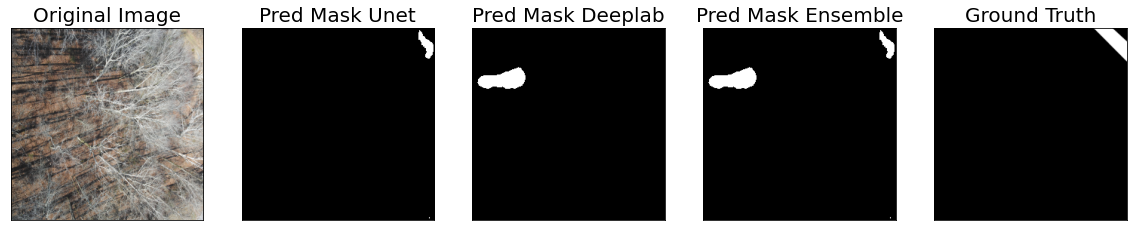

Ensemble IoU:  tensor(0.3073)
Ensemble Dice Loss:  tensor(0.5297)
UNet IoU:  tensor(0.3082)
UNet Dice Loss:  tensor(0.5286)
DeepLab IoU:  tensor(0.0495)
DeepLab Dice Loss:  tensor(0.9053)


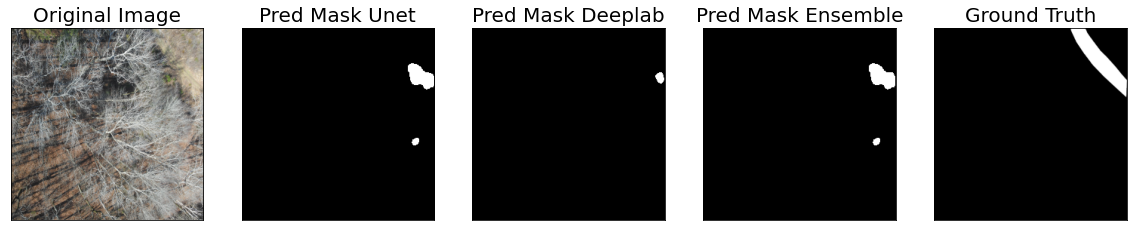

Ensemble IoU:  tensor(0.4403)
Ensemble Dice Loss:  tensor(0.3885)
UNet IoU:  tensor(0.4529)
UNet Dice Loss:  tensor(0.3765)
DeepLab IoU:  tensor(0.2273)
DeepLab Dice Loss:  tensor(0.6294)


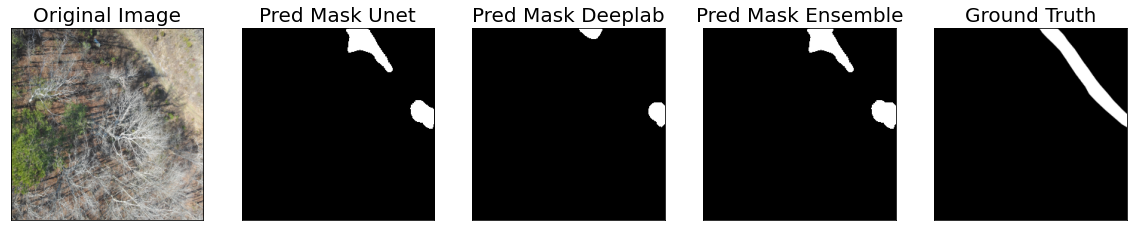

Ensemble IoU:  tensor(0.4400)
Ensemble Dice Loss:  tensor(0.3888)
UNet IoU:  tensor(0.4967)
UNet Dice Loss:  tensor(0.3363)
DeepLab IoU:  tensor(0.2136)
DeepLab Dice Loss:  tensor(0.6479)


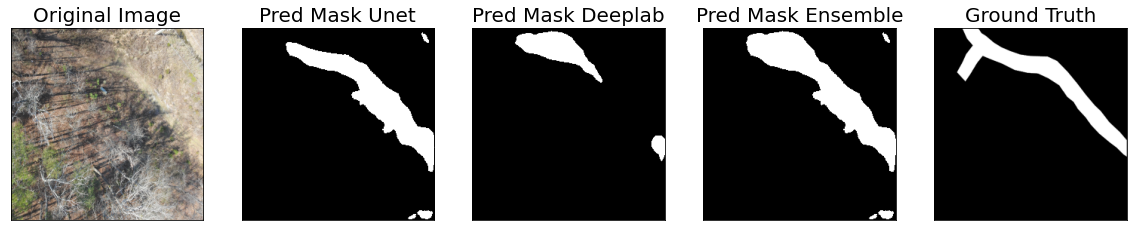

Ensemble IoU:  tensor(0.4105)
Ensemble Dice Loss:  tensor(0.4179)
UNet IoU:  tensor(0.5067)
UNet Dice Loss:  tensor(0.3274)
DeepLab IoU:  tensor(0.2826)
DeepLab Dice Loss:  tensor(0.5593)


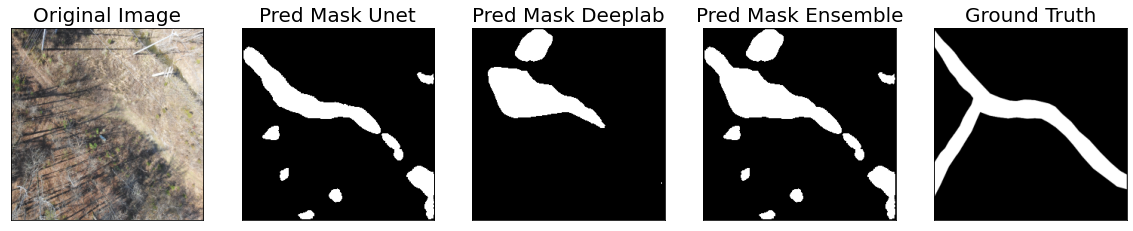

Ensemble IoU:  tensor(0.4794)
Ensemble Dice Loss:  tensor(0.3519)
UNet IoU:  tensor(0.5120)
UNet Dice Loss:  tensor(0.3228)
DeepLab IoU:  tensor(0.3107)
DeepLab Dice Loss:  tensor(0.5259)


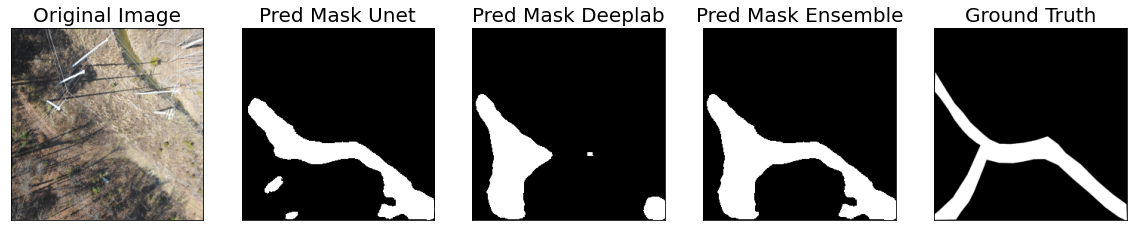

Ensemble IoU:  tensor(0.3258)
Ensemble Dice Loss:  tensor(0.5084)
UNet IoU:  tensor(0.2661)
UNet Dice Loss:  tensor(0.5796)
DeepLab IoU:  tensor(0.0677)
DeepLab Dice Loss:  tensor(0.8730)


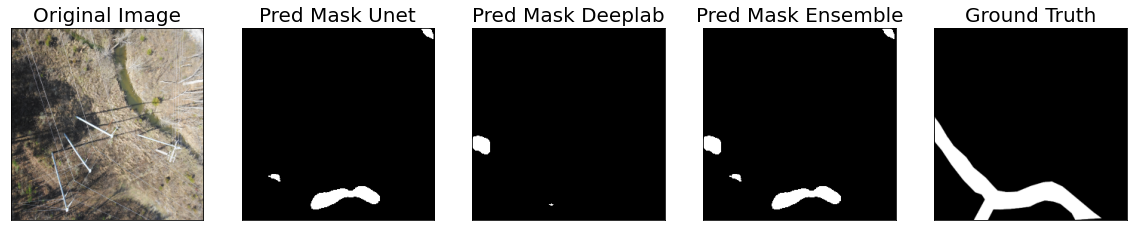

Ensemble IoU:  tensor(0.2413)
Ensemble Dice Loss:  tensor(0.6109)
UNet IoU:  tensor(5.6561e-11)
UNet Dice Loss:  tensor(0.9994)
DeepLab IoU:  tensor(0.4786)
DeepLab Dice Loss:  tensor(0.3524)


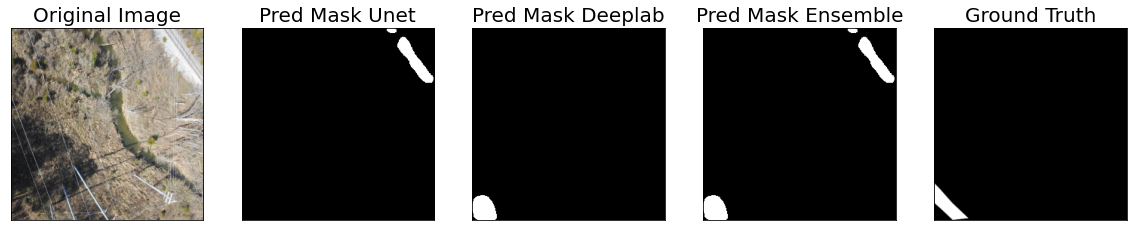

Ensemble IoU:  tensor(0.0204)
Ensemble Dice Loss:  tensor(0.9600)
UNet IoU:  tensor(0.0256)
UNet Dice Loss:  tensor(0.9499)
DeepLab IoU:  tensor(1.5300e-11)
DeepLab Dice Loss:  tensor(0.9998)


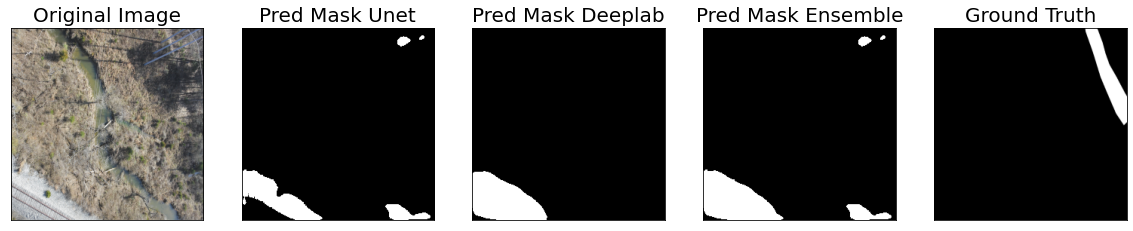

Ensemble IoU:  tensor(0.0084)
Ensemble Dice Loss:  tensor(0.9830)
UNet IoU:  tensor(0.0084)
UNet Dice Loss:  tensor(0.9830)
DeepLab IoU:  tensor(4.5998e-11)
DeepLab Dice Loss:  tensor(0.9995)


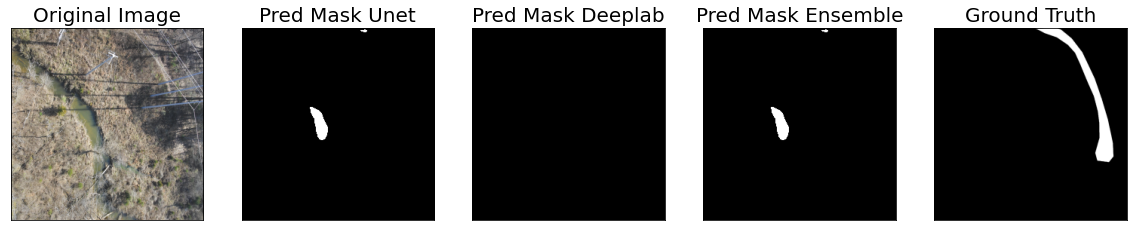

Ensemble IoU:  tensor(0.3068)
Ensemble Dice Loss:  tensor(0.5304)
UNet IoU:  tensor(0.3029)
UNet Dice Loss:  tensor(0.5350)
DeepLab IoU:  tensor(0.1101)
DeepLab Dice Loss:  tensor(0.8015)


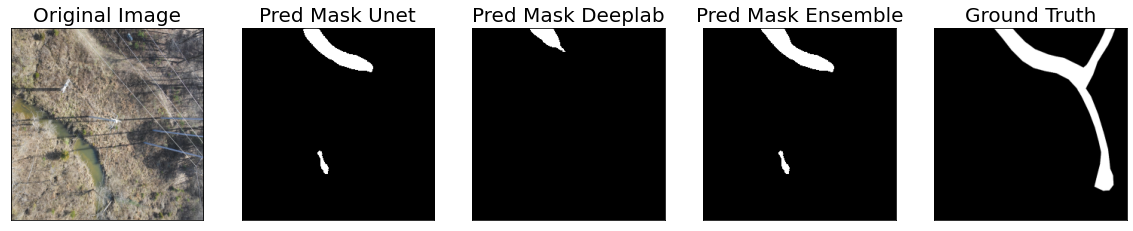

Ensemble IoU:  tensor(0.3367)
Ensemble Dice Loss:  tensor(0.4962)
UNet IoU:  tensor(0.3019)
UNet Dice Loss:  tensor(0.5362)
DeepLab IoU:  tensor(0.3300)
DeepLab Dice Loss:  tensor(0.5037)


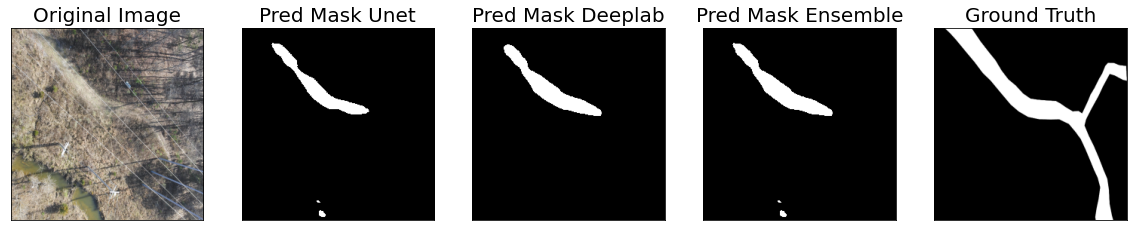

Ensemble IoU:  tensor(0.4956)
Ensemble Dice Loss:  tensor(0.3372)
UNet IoU:  tensor(0.4404)
UNet Dice Loss:  tensor(0.3884)
DeepLab IoU:  tensor(0.4162)
DeepLab Dice Loss:  tensor(0.4122)


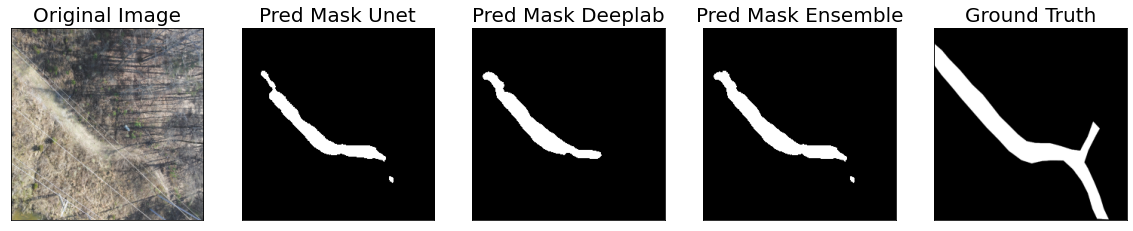

Ensemble IoU:  tensor(0.5899)
Ensemble Dice Loss:  tensor(0.2579)
UNet IoU:  tensor(0.5189)
UNet Dice Loss:  tensor(0.3167)
DeepLab IoU:  tensor(0.4450)
DeepLab Dice Loss:  tensor(0.3841)


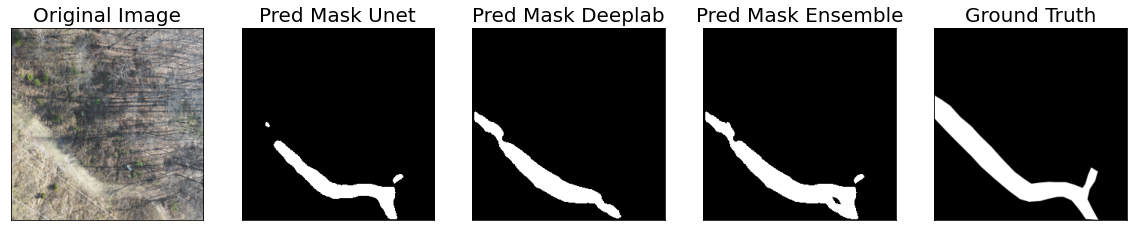

Ensemble IoU:  tensor(0.5526)
Ensemble Dice Loss:  tensor(0.2881)
UNet IoU:  tensor(0.5512)
UNet Dice Loss:  tensor(0.2893)
DeepLab IoU:  tensor(0.3713)
DeepLab Dice Loss:  tensor(0.4584)


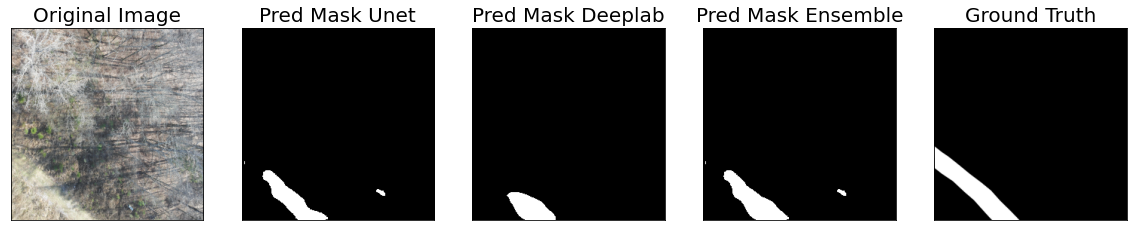

Ensemble IoU:  tensor(0.0145)
Ensemble Dice Loss:  tensor(0.9713)
UNet IoU:  tensor(0.0148)
UNet Dice Loss:  tensor(0.9707)
DeepLab IoU:  tensor(3.7414e-12)
DeepLab Dice Loss:  tensor(1.0000)


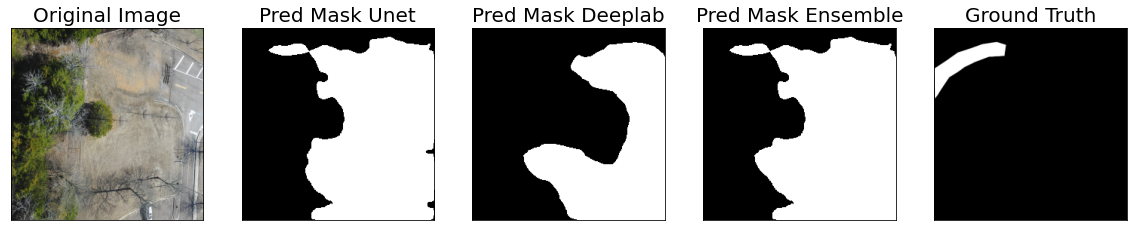

Ensemble IoU:  tensor(0.0284)
Ensemble Dice Loss:  tensor(0.9448)
UNet IoU:  tensor(0.0291)
UNet Dice Loss:  tensor(0.9433)
DeepLab IoU:  tensor(0.0038)
DeepLab Dice Loss:  tensor(0.9924)


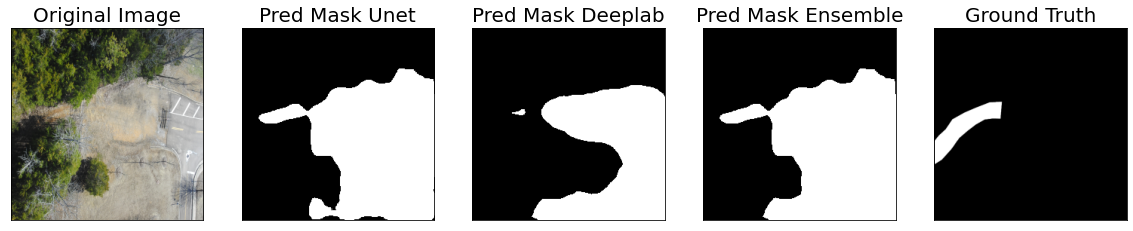

Ensemble IoU:  tensor(0.0495)
Ensemble Dice Loss:  tensor(0.9056)
UNet IoU:  tensor(0.0496)
UNet Dice Loss:  tensor(0.9054)
DeepLab IoU:  tensor(5.3686e-12)
DeepLab Dice Loss:  tensor(0.9999)


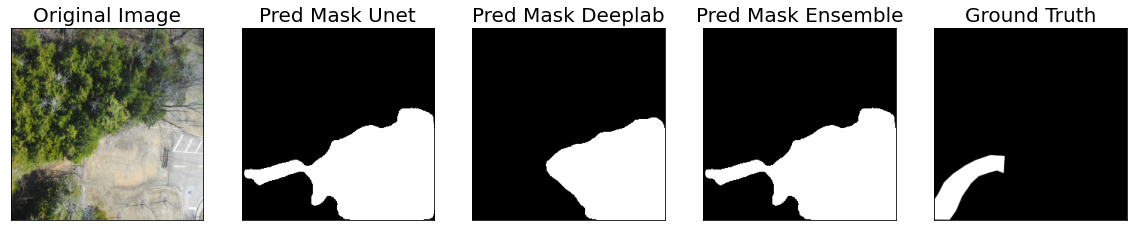

Ensemble IoU:  tensor(0.6779)
Ensemble Dice Loss:  tensor(0.1919)
UNet IoU:  tensor(0.7958)
UNet Dice Loss:  tensor(0.1137)
DeepLab IoU:  tensor(0.6799)
DeepLab Dice Loss:  tensor(0.1905)


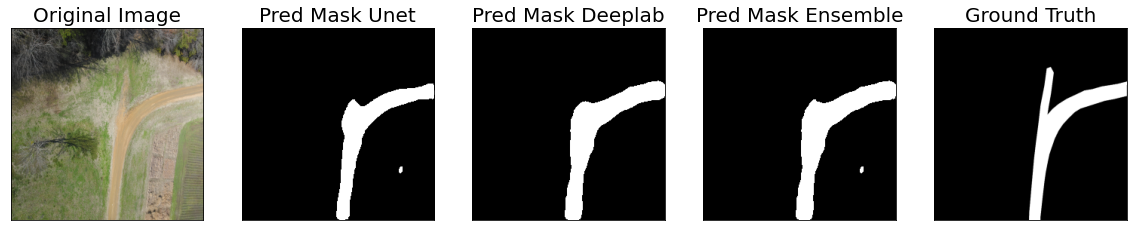

Ensemble IoU:  tensor(0.6622)
Ensemble Dice Loss:  tensor(0.2032)
UNet IoU:  tensor(0.7741)
UNet Dice Loss:  tensor(0.1273)
DeepLab IoU:  tensor(0.6595)
DeepLab Dice Loss:  tensor(0.2051)


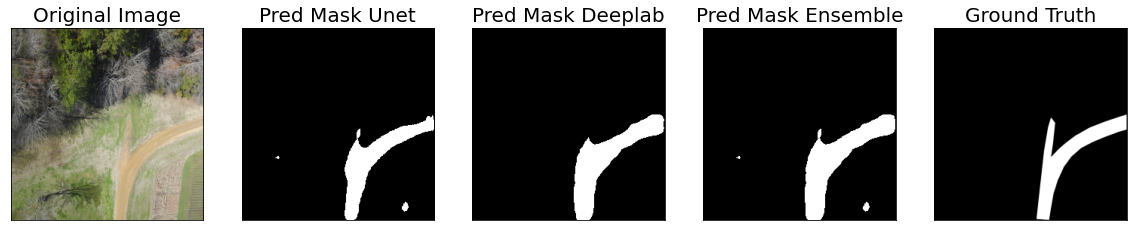

Ensemble IoU:  tensor(0.6520)
Ensemble Dice Loss:  tensor(0.2106)
UNet IoU:  tensor(0.7076)
UNet Dice Loss:  tensor(0.1712)
DeepLab IoU:  tensor(0.5494)
DeepLab Dice Loss:  tensor(0.2908)


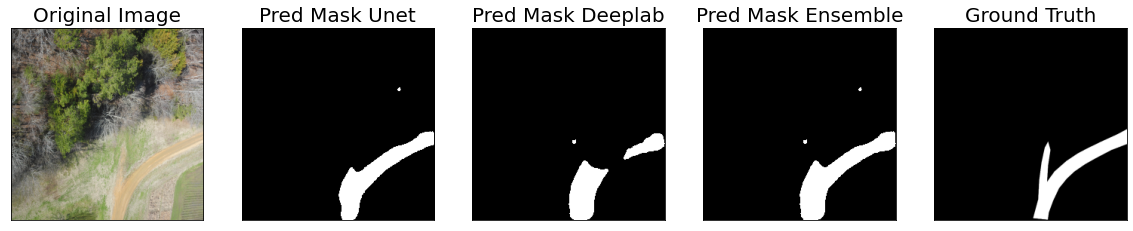

Ensemble IoU:  tensor(0.4709)
Ensemble Dice Loss:  tensor(0.3596)
UNet IoU:  tensor(0.4709)
UNet Dice Loss:  tensor(0.3596)
DeepLab IoU:  tensor(0.0299)
DeepLab Dice Loss:  tensor(0.9416)


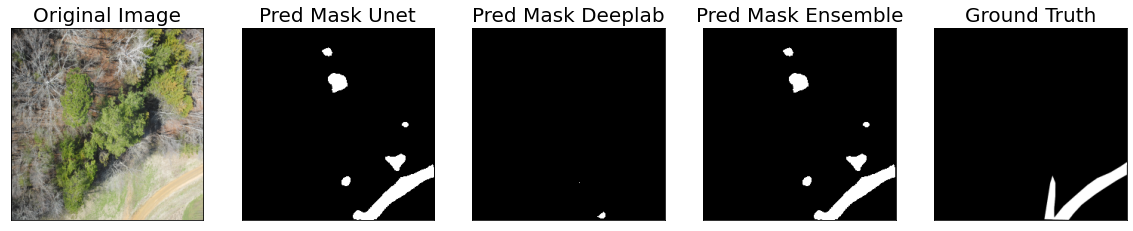

Ensemble IoU:  tensor(0.2616)
Ensemble Dice Loss:  tensor(0.5851)
UNet IoU:  tensor(0.4062)
UNet Dice Loss:  tensor(0.4221)
DeepLab IoU:  tensor(0.2421)
DeepLab Dice Loss:  tensor(0.6100)


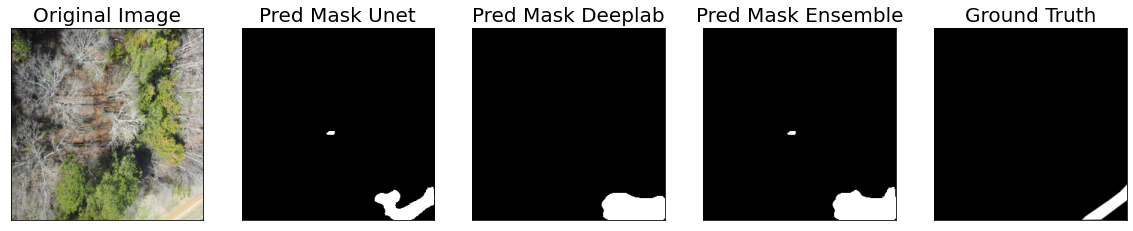

Ensemble IoU:  tensor(0.3865)
Ensemble Dice Loss:  tensor(0.4425)
UNet IoU:  tensor(0.4064)
UNet Dice Loss:  tensor(0.4221)
DeepLab IoU:  tensor(0.3716)
DeepLab Dice Loss:  tensor(0.4581)


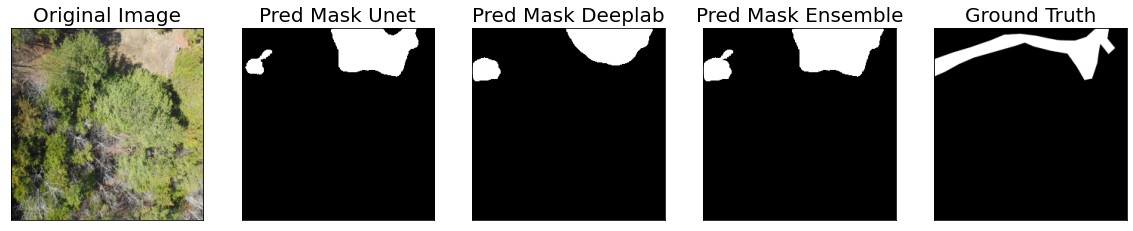

Ensemble IoU:  tensor(0.4318)
Ensemble Dice Loss:  tensor(0.3969)
UNet IoU:  tensor(0.4745)
UNet Dice Loss:  tensor(0.3564)
DeepLab IoU:  tensor(0.4299)
DeepLab Dice Loss:  tensor(0.3987)


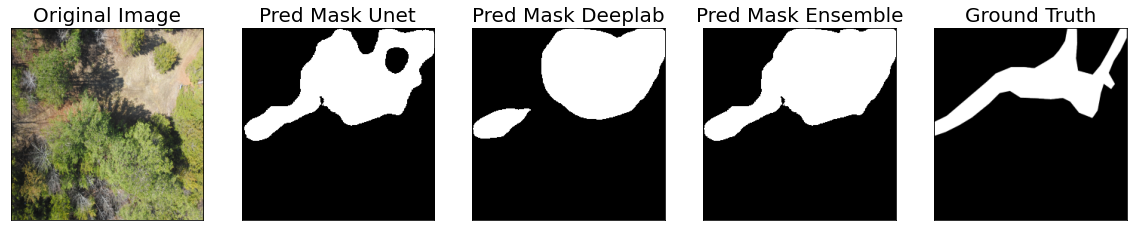

Ensemble IoU:  tensor(0.6322)
Ensemble Dice Loss:  tensor(0.2253)
UNet IoU:  tensor(0.6576)
UNet Dice Loss:  tensor(0.2065)
DeepLab IoU:  tensor(0.5785)
DeepLab Dice Loss:  tensor(0.2670)


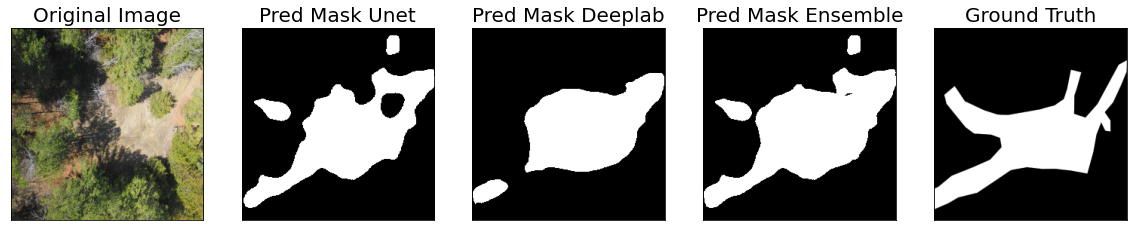

Ensemble IoU:  tensor(0.5508)
Ensemble Dice Loss:  tensor(0.2896)
UNet IoU:  tensor(0.5840)
UNet Dice Loss:  tensor(0.2626)
DeepLab IoU:  tensor(0.5356)
DeepLab Dice Loss:  tensor(0.3024)


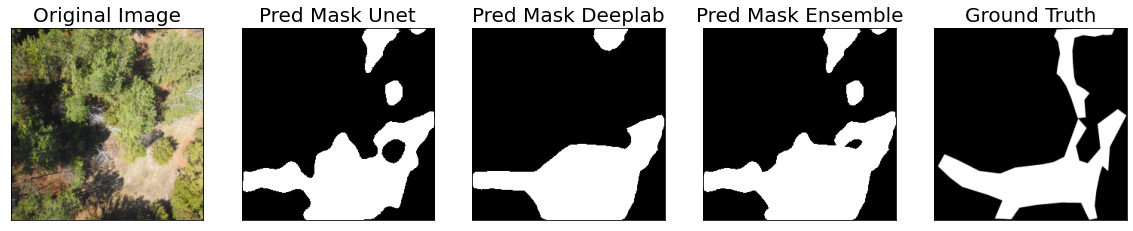

Ensemble IoU:  tensor(0.4902)
Ensemble Dice Loss:  tensor(0.3421)
UNet IoU:  tensor(0.4868)
UNet Dice Loss:  tensor(0.3452)
DeepLab IoU:  tensor(0.3719)
DeepLab Dice Loss:  tensor(0.4578)


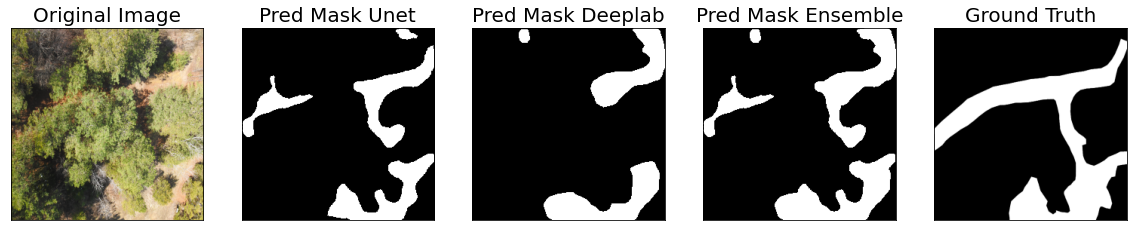

Ensemble IoU:  tensor(0.3418)
Ensemble Dice Loss:  tensor(0.4905)
UNet IoU:  tensor(0.3480)
UNet Dice Loss:  tensor(0.4837)
DeepLab IoU:  tensor(0.1568)
DeepLab Dice Loss:  tensor(0.7289)


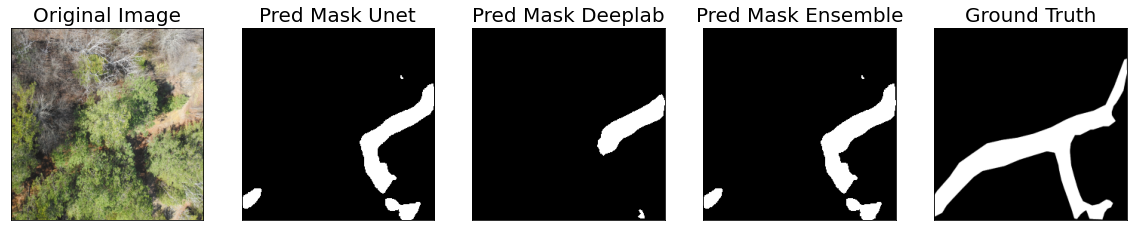

Ensemble IoU:  tensor(0.2955)
Ensemble Dice Loss:  tensor(0.5436)
UNet IoU:  tensor(0.3004)
UNet Dice Loss:  tensor(0.5378)
DeepLab IoU:  tensor(0.2140)
DeepLab Dice Loss:  tensor(0.6472)


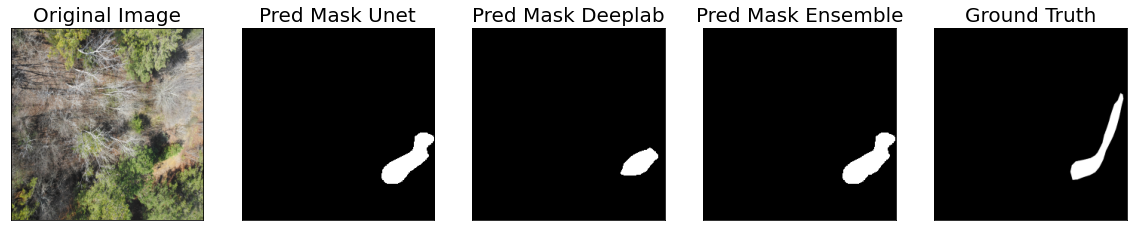

Ensemble IoU:  tensor(0.4502)
Ensemble Dice Loss:  tensor(0.3790)
UNet IoU:  tensor(0.4869)
UNet Dice Loss:  tensor(0.3450)
DeepLab IoU:  tensor(0.2898)
DeepLab Dice Loss:  tensor(0.5504)


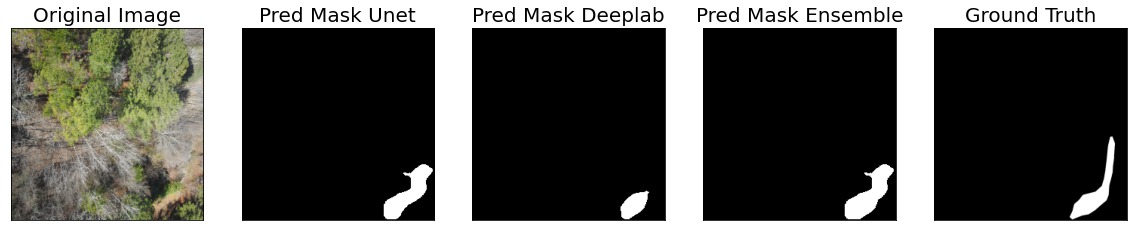

Ensemble IoU:  tensor(0.0268)
Ensemble Dice Loss:  tensor(0.9475)
UNet IoU:  tensor(0.0418)
UNet Dice Loss:  tensor(0.9193)
DeepLab IoU:  tensor(3.1586e-11)
DeepLab Dice Loss:  tensor(0.9997)


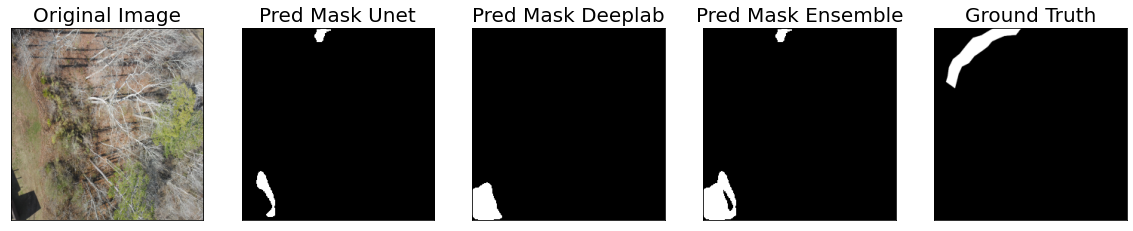

Ensemble IoU:  tensor(0.0838)
Ensemble Dice Loss:  tensor(0.8452)
UNet IoU:  tensor(0.0838)
UNet Dice Loss:  tensor(0.8452)
DeepLab IoU:  tensor(0.0002)
DeepLab Dice Loss:  tensor(0.9993)


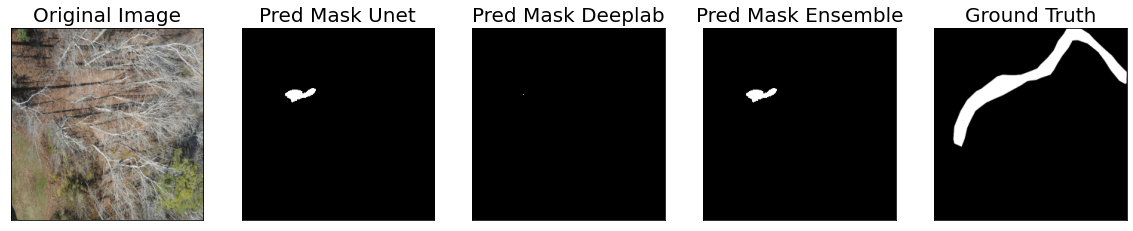

Ensemble IoU:  tensor(1.5267e-11)
Ensemble Dice Loss:  tensor(0.9998)
UNet IoU:  tensor(1.5267e-11)
UNet Dice Loss:  tensor(0.9998)
DeepLab IoU:  tensor(1.5267e-11)
DeepLab Dice Loss:  tensor(0.9998)


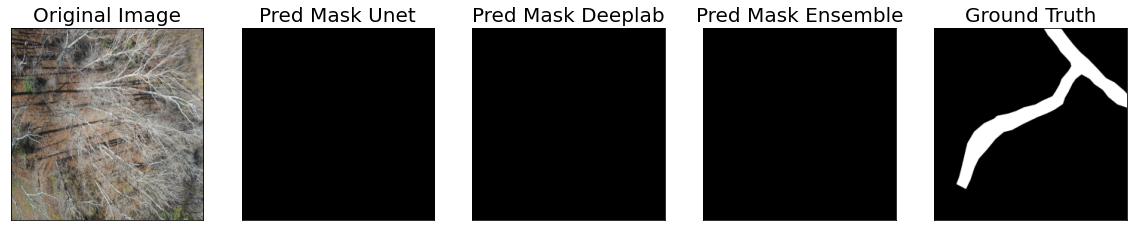

Ensemble IoU:  tensor(0.1399)
Ensemble Dice Loss:  tensor(0.7544)
UNet IoU:  tensor(0.1399)
UNet Dice Loss:  tensor(0.7544)
DeepLab IoU:  tensor(1.9833e-11)
DeepLab Dice Loss:  tensor(0.9998)


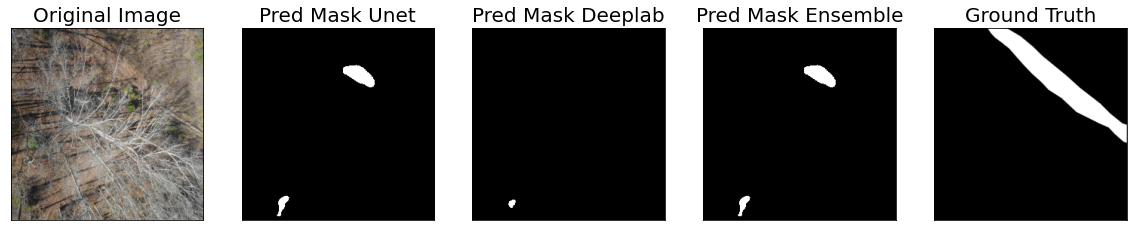

Ensemble IoU:  tensor(0.2875)
Ensemble Dice Loss:  tensor(0.5533)
UNet IoU:  tensor(0.3867)
UNet Dice Loss:  tensor(0.4422)
DeepLab IoU:  tensor(0.2615)
DeepLab Dice Loss:  tensor(0.5854)


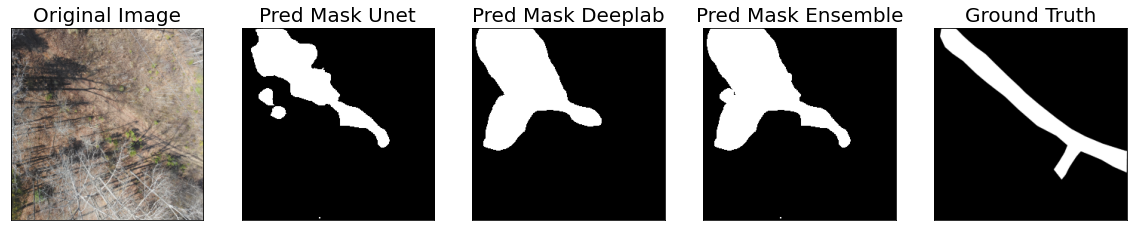

Ensemble IoU:  tensor(0.3794)
Ensemble Dice Loss:  tensor(0.4499)
UNet IoU:  tensor(0.4166)
UNet Dice Loss:  tensor(0.4118)
DeepLab IoU:  tensor(0.3692)
DeepLab Dice Loss:  tensor(0.4607)


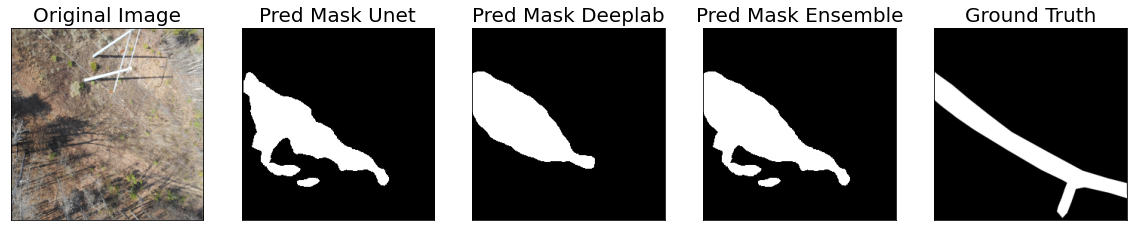

Ensemble IoU:  tensor(0.4344)
Ensemble Dice Loss:  tensor(0.3943)
UNet IoU:  tensor(0.3671)
UNet Dice Loss:  tensor(0.4629)
DeepLab IoU:  tensor(0.4669)
DeepLab Dice Loss:  tensor(0.3634)


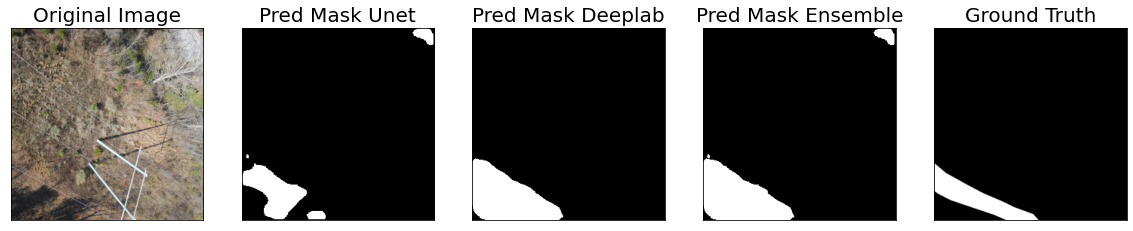

Ensemble IoU Score: 0.33839380741119385
Ensemble Dice Loss: 0.5317084193229675
UNet IoU Score: 0.3556317985057831
UNet Dice Loss: 0.5187438130378723
DeepLab IoU Score: 0.25034207105636597
DeepLab Dice Loss: 0.6447601914405823


In [21]:
import pickle

iou_score = 0
dice_loss = 0

u_iou_score = 0
u_dice_loss = 0

d_iou_score = 0
d_dice_loss = 0


for idx in range(len(test_dataset)):
    
    image, gt_mask = test_dataset[idx]
    image = preprocess_resize_image(image)

    image_vis, gt_mask_vis = test_dataset_vis[idx]
    image_vis = cv2.resize(image_vis.astype('uint8'), (256, 256), interpolation = cv2.INTER_AREA)
    gt_mask_vis = cv2.resize(colour_code_segmentation(reverse_one_hot(gt_mask_vis), select_class_rgb_values).astype('uint8'), (256, 256), interpolation = cv2.INTER_AREA)

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pred_mask_unet = best_model_unet(x_tensor)
    pred_mask_deepLab = best_model_deepLab(x_tensor)

    pred_mask_unet = pred_mask_unet.detach().squeeze().cpu().numpy()
    pred_mask_deepLab = pred_mask_deepLab.detach().squeeze().cpu().numpy()

    pred_mask_unet = np.transpose(pred_mask_unet,(1,2,0))
    pred_mask_deepLab = np.transpose(pred_mask_deepLab,(1,2,0))
    pred_mask_ensemble = get_ensemble_maxpool_prediction(pred_mask_unet, pred_mask_deepLab)

    # with open(os.path.join(sample_preds_folder, prediction_matrix, f"sample_pred_{idx}.pkl"), 'wb') as f:
    #     pickle.dump(pred_mask_ensemble, f)

    pred_mask_unet = colour_code_segmentation(reverse_one_hot(pred_mask_unet), select_class_rgb_values)
    pred_mask_deepLab = colour_code_segmentation(reverse_one_hot(pred_mask_deepLab), select_class_rgb_values)
    pred_mask_ensemble = colour_code_segmentation(reverse_one_hot(pred_mask_ensemble), select_class_rgb_values)

    im_gray = cv2.cvtColor(gt_mask_vis.astype('uint8'), cv2.COLOR_BGR2GRAY)
    pm_gray = cv2.cvtColor(pred_mask_ensemble.astype('uint8'), cv2.COLOR_BGR2GRAY)
    u_pm_gray = cv2.cvtColor(pred_mask_unet.astype('uint8'), cv2.COLOR_BGR2GRAY)
    d_pm_gray = cv2.cvtColor(pred_mask_deepLab.astype('uint8'), cv2.COLOR_BGR2GRAY)

    pm_gray = pm_gray == 255
    im_gray = im_gray == 255
    u_pm_gray = u_pm_gray == 255
    d_pm_gray = d_pm_gray == 255

    temp_iou = get_iou_score(torch.tensor(pm_gray), torch.tensor(im_gray))
    temp_dice = get_dice_loss(torch.tensor(pm_gray), torch.tensor(im_gray))

    iou_score += temp_iou
    dice_loss += temp_dice

    print("Ensemble IoU: ", temp_iou)
    print("Ensemble Dice Loss: ", temp_dice)

    temp_iou = get_iou_score(torch.tensor(u_pm_gray), torch.tensor(im_gray))
    temp_dice = get_dice_loss(torch.tensor(u_pm_gray), torch.tensor(im_gray))

    u_iou_score += temp_iou
    u_dice_loss += temp_dice

    print("UNet IoU: ", temp_iou)
    print("UNet Dice Loss: ", temp_dice)

    temp_iou = get_iou_score(torch.tensor(d_pm_gray), torch.tensor(im_gray))
    temp_dice = get_dice_loss(torch.tensor(d_pm_gray), torch.tensor(im_gray))

    d_iou_score += temp_iou
    d_dice_loss += temp_dice

    print("DeepLab IoU: ", temp_iou)
    print("DeepLab Dice Loss: ", temp_dice)

    # Get prediction channel corresponding to road
    # pred_road_heatmap = pred_mask_ensemble[:,:,select_classes.index('road')]
    # pred_road_heatmap = cv2.cvtColor(pred_road_heatmap, cv2.COLOR_BGR2RGB)

    # cv2.imwrite(os.path.join(sample_preds_folder, original_image_folder, f"sample_pred_{idx}.png"), cv2.cvtColor(image_vis, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(os.path.join(sample_preds_folder, predictions_folder, f"sample_pred_{idx}.png"), pred_mask_ensemble)
    # cv2.imwrite(os.path.join(sample_preds_folder, ground_truth_folder, f"sample_pred_{idx}.png"), gt_mask_vis)

    visualize(
        original_image = image_vis,
        pred_mask_unet = pred_mask_unet,
        pred_mask_deepLab = pred_mask_deepLab,
        pred_mask_ensemble = pred_mask_ensemble,
        ground_truth = gt_mask_vis
    )

print(f"Ensemble IoU Score: {iou_score/len(test_dataset)}")
print(f"Ensemble Dice Loss: {dice_loss/len(test_dataset)}")

print(f"UNet IoU Score: {u_iou_score/len(test_dataset)}")
print(f"UNet Dice Loss: {u_dice_loss/len(test_dataset)}")

print(f"DeepLab IoU Score: {d_iou_score/len(test_dataset)}")
print(f"DeepLab Dice Loss: {d_dice_loss/len(test_dataset)}")

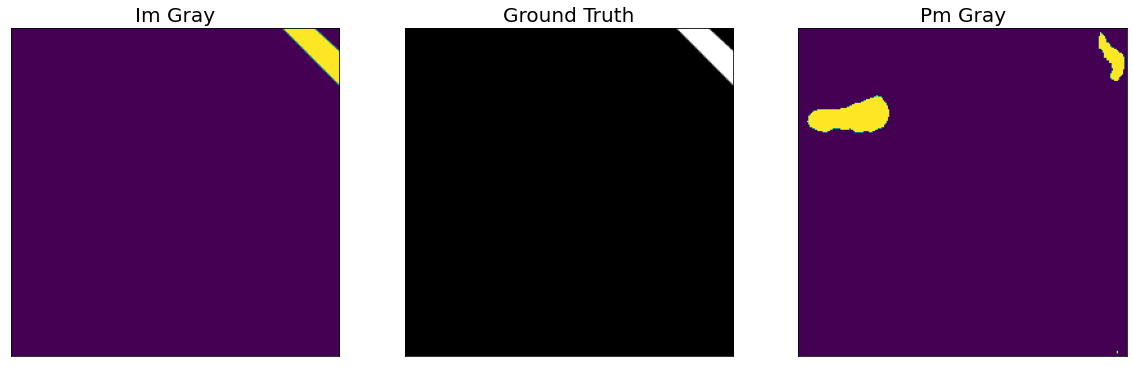

(256, 256)
(256, 256)
bool
<class 'numpy.ndarray'>
tensor(1.)
tensor(0.)


In [ ]:
gt_mask_vis = cv2.resize(gt_mask_vis.astype('uint8'), (256, 256), interpolation = cv2.INTER_AREA)
im_gray = cv2.cvtColor(gt_mask_vis, cv2.COLOR_BGR2GRAY)
pm_gray = cv2.cvtColor(pred_mask_ensemble.astype('uint8'), cv2.COLOR_BGR2GRAY)
visualize(
        im_gray = im_gray,
        ground_truth = gt_mask_vis,
        pm_gray= pm_gray
    )

pm_gray = pm_gray == 255
im_gray = im_gray == 255

print(pm_gray.shape)
print(im_gray.shape)
print(im_gray.dtype)
print(type(pm_gray))
print(get_iou_score(torch.tensor(im_gray), torch.tensor(im_gray)))
print(get_dice_loss(torch.tensor(im_gray), torch.tensor(im_gray)))


In [22]:
# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [23]:
test_epoch = smp.utils.train.ValidEpoch(
    best_model_unet,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 38/38 [02:07<00:00,  3.35s/it, dice_loss - 0.184, iou_score - 0.7458]
Evaluation on Test Data: 
Mean IoU Score: 0.7458
Mean Dice Loss: 0.1840


In [24]:
test_epoch = smp.utils.train.ValidEpoch(
    best_model_deepLab,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 38/38 [02:11<00:00,  3.45s/it, dice_loss - 0.2425, iou_score - 0.6984]
Evaluation on Test Data: 
Mean IoU Score: 0.6984
Mean Dice Loss: 0.2425
